In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#import dataset
df=pd.read_csv("/content/drive/MyDrive/Salaries.csv")

In [ ]:
df.head()

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.00,400184.25,NaN,567595.43,567595.43,2011,NaN,San Francisco,NaN
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,NaN,538909.28,538909.28,2011,NaN,San Francisco,NaN
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.60,NaN,335279.91,335279.91,2011,NaN,San Francisco,NaN
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.00,56120.71,198306.90,NaN,332343.61,332343.61,2011,NaN,San Francisco,NaN
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.60,9737.00,182234.59,NaN,326373.19,326373.19,2011,NaN,San Francisco,NaN


### **DATA EXPLORATION**

In [ ]:
#checking the dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148654 entries, 0 to 148653
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Id                148654 non-null  int64  
 1   EmployeeName      148654 non-null  object 
 2   JobTitle          148654 non-null  object 
 3   BasePay           148045 non-null  float64
 4   OvertimePay       148650 non-null  float64
 5   OtherPay          148650 non-null  float64
 6   Benefits          112491 non-null  float64
 7   TotalPay          148654 non-null  float64
 8   TotalPayBenefits  148654 non-null  float64
 9   Year              148654 non-null  int64  
 10  Notes             0 non-null       float64
 11  Agency            148654 non-null  object 
 12  Status            0 non-null       float64
dtypes: float64(8), int64(2), object(3)
memory usage: 14.7+ MB


In [ ]:
# Statistical summary of the dataset
print("\nStatistical summary of the dataset:")
df.describe()


Statistical summary of the dataset:


,Id,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Status
count,148654.000000,148654.000000,148654.000000,148654.000000,148654.000000,148654.000000,148654.000000,148654.000000,0.0,0.0
mean,74327.500000,66325.448840,5066.059886,3648.767297,25007.893151,74768.321972,93692.554811,2012.522643,NaN,NaN
std,42912.857795,42676.946745,11454.226449,8056.493470,13398.411899,50517.005274,62793.533483,1.117538,NaN,NaN
min,1.000000,-166.010000,-0.010000,-7058.590000,-33.890000,-618.130000,-618.130000,2011.000000,NaN,NaN
25%,37164.250000,33847.017500,0.000000,0.000000,22342.297500,36168.995000,44065.650000,2012.000000,NaN,NaN
50%,74327.500000,65092.190000,0.000000,811.350000,25007.893151,71426.610000,92404.090000,2013.000000,NaN,NaN
75%,111490.750000,94605.740000,4658.667500,4235.907500,33468.980000,105839.135000,132876.450000,2014.000000,NaN,NaN
max,148654.000000,319275.010000,245131.880000,400184.250000,96570.660000,567595.430000,567595.430000,2014.000000,NaN,NaN


In [ ]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Handle missing values
categorical_columns = df.select_dtypes(include=['object']).columns
numerical_columns = df.select_dtypes(exclude=['object']).columns  # Exclude 'period' data type

# Replace categorical null values with mode
for col in categorical_columns:
    mode_value = df[col].mode()[0]
    df[col].fillna(mode_value, inplace=True)

# Replace numerical null values with mean
for col in numerical_columns:
    if df[col].dtype == 'period':
        # For 'period' data type, replace null values with the start timestamp mean
        mean_value = df[col].dt.to_timestamp(how='start').mean()
        df[col].fillna(mean_value, inplace=True)
    else:
        # For other numerical columns, replace null values with mean
        mean_value = df[col].mean()
        df[col].fillna(mean_value, inplace=True)

# Verify if there are any remaining null values
print("\nMissing values after handling:")
print(df.isnull().any())


Missing values:
Id                       0
EmployeeName             0
JobTitle                 0
BasePay                609
OvertimePay              4
OtherPay                 4
Benefits             36163
TotalPay                 0
TotalPayBenefits         0
Year                     0
Notes               148654
Agency                   0
Status              148654
dtype: int64

Missing values after handling:
Id                  False
EmployeeName        False
JobTitle            False
BasePay             False
OvertimePay         False
OtherPay            False
Benefits            False
TotalPay            False
TotalPayBenefits    False
Year                False
Notes                True
Agency              False
Status               True
dtype: bool


In [ ]:
salary_range = df['TotalPay'].describe()[['min', 'max']]

# Display the salary range
print("Salary Range:")
print(salary_range)

Salary Range:
min      -618.13
max    567595.43
Name: TotalPay, dtype: float64


In [ ]:
import re

# Define a function to extract department information from job titles
def extract_department(job_title):
    # Use regular expression to find text inside parentheses
    match = re.search(r'\((.*?)\)', job_title)

    # If there is a match, return the text inside parentheses; otherwise, return 'Other'
    return match.group(1) if match else 'Other'

# Apply the function to create the 'DEP' column
df['DEP'] = df['JobTitle'].apply(extract_department)

# Display the unique departments
unique_departments = df['DEP'].unique()
print("Unique Departments:", unique_departments)


Unique Departments: ['Other' 'POLICE DEPARTMENT' 'FIRE DEPARTMENT' 'CIVIL & CRIMINAL'
 'CIVIL/CRIMINAL' 'MFCC' 'SEASONAL' 'Fire Dept' 'Cvl&Crmnl'
 'Civil & Criminal' 'SFERS' 'Police Department' 'Civil/Criminal'
 'Seasonal' 'Fire Department']


In [ ]:
# Display the updated DataFrame with the new 'DEP' column
print(df[['JobTitle', 'DEP']].head())


                                         JobTitle                DEP
0  GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY              Other
1                 CAPTAIN III (POLICE DEPARTMENT)  POLICE DEPARTMENT
2                 CAPTAIN III (POLICE DEPARTMENT)  POLICE DEPARTMENT
3            WIRE ROPE CABLE MAINTENANCE MECHANIC              Other
4    DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)    FIRE DEPARTMENT


### **DATA VISUALIZATION**

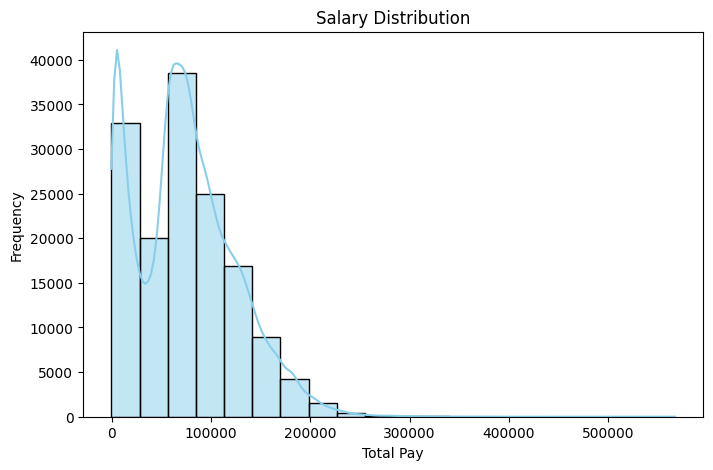

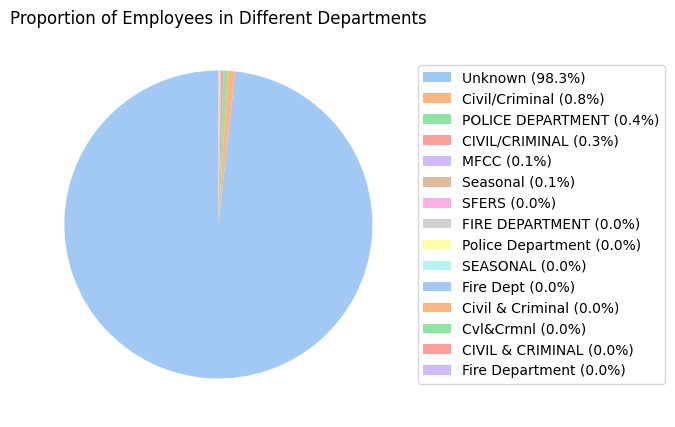

In [ ]:
# Histogram for salary distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['TotalPay'], bins=20, kde=True, color='skyblue')
plt.title('Salary Distribution')
plt.xlabel('Total Pay')
plt.ylabel('Frequency')
plt.show()

# Pie chart for the proportion of employees in different departments
plt.figure(figsize=(8, 5))
department_counts = df['DEP'].value_counts()
colors = sns.color_palette('pastel')

# Display percentages next to the legend
plt.pie(department_counts, labels=None, startangle=90, colors=colors, autopct='')

# Create a legend with percentages
legend_labels = [f'{dep} ({count/len(df)*100:.1f}%)' for dep, count in zip(department_counts.index, department_counts)]
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))

plt.title('Proportion of Employees in Different Departments')
plt.show()

In [ ]:
# Example using z-score to identify and remove outliers
from scipy.stats import zscore

# Calculate z-scores for 'TotalPay' column
z_scores = zscore(df['TotalPay'])

# Define a threshold for outliers (e.g., z-score > 3 or < -3)
threshold = 3

# Keep only rows where z-score is within the threshold
df_no_outliers = df[(z_scores < threshold) & (z_scores > -threshold)]


In [ ]:
# Example using log transformation
df['LogTotalPay'] = np.log1p(df['TotalPay'])


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Example using StandardScaler
scaler = StandardScaler()
df['TotalPay_scaled'] = scaler.fit_transform(df[['TotalPay']])


In [ ]:
# Group by 'DEP' (department) and calculate the average salary for each department
average_salary_by_department = df.groupby('DEP')['TotalPay'].mean()

# Display the result
print(average_salary_by_department)


DEP
CIVIL & CRIMINAL     181415.143750
CIVIL/CRIMINAL       128056.733820
Civil & Criminal     203727.389286
Civil/Criminal       137961.430036
Cvl&Crmnl            215085.310000
FIRE DEPARTMENT      221158.444615
Fire Department       35332.780000
Fire Dept            276063.426400
MFCC                  67517.330222
Other                 73673.398022
POLICE DEPARTMENT    158810.073568
Police Department    152696.334444
SEASONAL               7488.975667
SFERS                 87697.342344
Seasonal              10043.225814
Name: TotalPay, dtype: float64


In [ ]:
# Calculate the correlation coefficient between 'TotalPay' and 'BasePay'
correlation_totalpay_basepay = df['TotalPay'].corr(df['BasePay'])

# Print the correlation coefficient
print(f"Correlation between TotalPay and BasePay: {correlation_totalpay_basepay}")


Correlation between TotalPay and BasePay: 0.9505142922626454


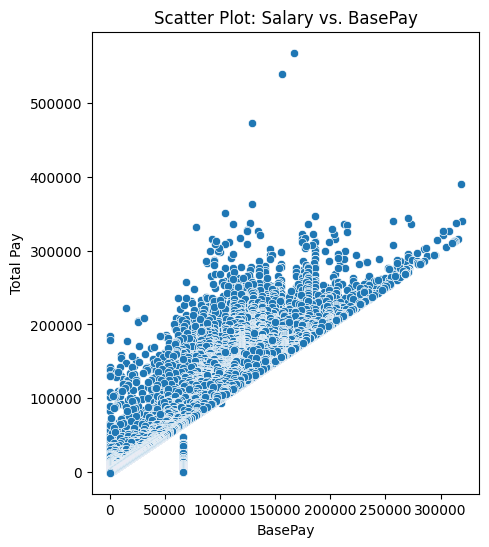

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example scatter plot
plt.figure(figsize=(5, 6))
sns.scatterplot(x='BasePay', y='TotalPay', data=df)
plt.title('Scatter Plot: Salary vs. BasePay')
plt.xlabel('BasePay')
plt.ylabel('Total Pay')
plt.show()